In [1]:
import copy
import random
import time
import os

import torch
import torch.nn
import torch.nn.functional 
import torch.optim 
import torch.utils.data

import torchvision.transforms
import torchvision.datasets
import torch.utils.data 
import skimage.io
import skimage.transform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Cleaning Data

In [3]:
labels_filepath = '../temp_assets/10x_labels.csv'
labels=pd.read_csv(labels_filepath)

In [4]:
labels.head(10)

,Sample,Sample origin,Description,Size (um),Identification
0,252_1,mussels,clear irregular,50,filter paper
1,252_2,mussels,opaque fiber,50,non-microplastic
2,252_3,mussels,opaque spheroid,25,non-microplastic
3,252_4,mussels,opaque fragment,75,polystyrene
4,252_5,mussels,opaque spheroid,50,non-microplastic
5,252_6,mussels,white spheroid,50,Nylon
6,252_7,mussels,opaque irregular,50,polystyrene
7,252_8,mussels,opaque irregular,30,filter paper
8,252_9,mussels,clear fragment,100,quartz
9,252_10,mussels,clear fragment,50,quartz


In [5]:
new= labels["Description"].str.split(" ", n = 1, expand = True)
labels.head(10)
new.head(10)
labels.drop(columns=['Description'],inplace=True)

In [6]:
labels['Color'] = new[0].values
labels['Shape'] = new[1].values

In [7]:
labels.head

<bound method NDFrame.head of                      Sample Sample origin  Size (um)    Identification  \
0                     252_1       mussels         50     filter paper    
1                     252_2       mussels         50  non-microplastic   
2                     252_3       mussels         25  non-microplastic   
3                     252_4       mussels         75       polystyrene   
4                     252_5       mussels         50  non-microplastic   
..                      ...           ...        ...               ...   
58   20201004 Set7Sample6_6         orcas         65  non-microplastic   
59   20201004 Set7Sample6_7         orcas        150      filter paper   
60   20201004 Set7Sample6_9         orcas         60  non-microplastic   
61  20201004 Set7Sample6_10         orcas         50      fluorescence   
62  20201004 Set7Sample6_12         orcas        150  non-microplastic   

     Color      Shape  
0    clear  irregular  
1   opaque      fiber  
2   opaqu

In [8]:
image_dir = '../temp_assets/images_10x'
os.listdir(image_dir)

['Set5Sample2_1 - 10x.bmp',
 'Set7Sample6_11 - 10x.bmp',
 '252_2 - 10x.bmp',
 '20190112 Illahee Oyster 2a - 10x.bmp',
 '20190112 Heritage Oyster 23b - 10x.bmp',
 '20191127 Set2Sample7d_10X.bmp',
 '20190114 NBay Oyster 13c - 10x.bmp',
 '20200817 73_2 - 10x.bmp',
 '20190110 Oakland Oyster 6a - 10x.bmp',
 'Set1Sample2_5 - 10x.bmp',
 '20191004 Set7Sample6_6 - 10x.bmp',
 '20190114 Jacoby Oyster 30c - 10x.bmp',
 'OaklandBay_Oyster 2a - 10x.bmp',
 '20191004 Set3Sample3_11 - 10x.bmp',
 '20190112 Illahee Oyster 1d - 10x.bmp',
 '20190113 Penrose Pt Oyster 20d - 10x.bmp',
 '20190110 Oakland Control 1-3a - 10x.bmp',
 '20200817 117_2 - 10x.bmp',
 '20190113 Penrose Pt Control 10-12a - 10x.bmp',
 'OaklandBay_Oyster 1d - 10x.bmp',
 '20150115 NBay Control 22-24a - 10x.bmp',
 '20190114 Jacoby Control 29-31c - 10x.bmp',
 '20150115 NBay Oyster 24c - 10x.bmp',
 '20191004 Set7Sample6_12 - 10x.bmp',
 '20190110 Oakland Oyster 5d - 10x.bmp',
 '20191004 Set3Sample3_9 - 10x.bmp',
 '20190112 Heritage Oyster 21c -

In [9]:
sample_names = labels["Sample"].str.split(" ", n = 1, expand = False)

for i in range(0,len(sample_names)):
    if len(sample_names[i])>1:
        sample_names[i] = sample_names[i][1]
    else:
        sample_names[i] = sample_names[i][0]
        
        
        
labels['Sample']=sample_names
labels.head

<bound method NDFrame.head of             Sample Sample origin  Size (um)    Identification   Color  \
0            252_1       mussels         50     filter paper    clear   
1            252_2       mussels         50  non-microplastic  opaque   
2            252_3       mussels         25  non-microplastic  opaque   
3            252_4       mussels         75       polystyrene  opaque   
4            252_5       mussels         50  non-microplastic  opaque   
..             ...           ...        ...               ...     ...   
58   Set7Sample6_6         orcas         65  non-microplastic  opaque   
59   Set7Sample6_7         orcas        150      filter paper  opaque   
60   Set7Sample6_9         orcas         60  non-microplastic  opaque   
61  Set7Sample6_10         orcas         50      fluorescence  opaque   
62  Set7Sample6_12         orcas        150  non-microplastic  opaque   

        Shape  
0   irregular  
1       fiber  
2    spheroid  
3    fragment  
4    spheroid

In [10]:
labels['Identification'].unique()

array(['filter paper ', 'non-microplastic', 'polystyrene', 'Nylon',
       'filter paper', 'quartz', 'carbon fiber', 'orthoclase',
       'polypropylene', 'ink + plastic', 'PET', 'polyethylene',
       'fluorescence'], dtype=object)

In [11]:
plastics = ['polystyrene', 'polyethylene','polypropylene','Nylon','ink + plastic','PET','carbon fiber']
identification = labels['Identification']

for i in range(0,len(identification)):
    if identification[i] in plastics:
        identification[i] = True
    else:
        identification[i] = False
    
identification.head
    

/Users/Will/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Will/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<bound method NDFrame.head of 0     False
1     False
2     False
3      True
4     False
      ...  
58    False
59    False
60    False
61    False
62    False
Name: Identification, Length: 63, dtype: object>

In [12]:
labels['Identification']=identification
labels.rename(columns={'Identification': 'isPlastic'}, inplace=True)
labels.head

<bound method NDFrame.head of             Sample Sample origin  Size (um) isPlastic   Color      Shape
0            252_1       mussels         50     False   clear  irregular
1            252_2       mussels         50     False  opaque      fiber
2            252_3       mussels         25     False  opaque   spheroid
3            252_4       mussels         75      True  opaque   fragment
4            252_5       mussels         50     False  opaque   spheroid
..             ...           ...        ...       ...     ...        ...
58   Set7Sample6_6         orcas         65     False  opaque  sphereoid
59   Set7Sample6_7         orcas        150     False  opaque  irregular
60   Set7Sample6_9         orcas         60     False  opaque  irregular
61  Set7Sample6_10         orcas         50     False  opaque  sphereoid
62  Set7Sample6_12         orcas        150     False  opaque  sphereoid

[63 rows x 6 columns]>

# Custom Dataset

In [24]:
class tenX_dataset(torch.utils.data.Dataset):
    """"""
    
    #Initializes dataset. Is only used once during the creating on a 'tenX_dataset' class
    #transform is an optional parameter, it defaults to none if nothing is passed into the class
    def __init__(self, labels_frame, image_dir, transform = None):
        'Initialization'
        self.labels = labels_frame
        self.image_dir = image_dir
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = None
        
    #Length of dataset
    def __len__(self):
        return len(self.labels)
    
    #Return an single image with labels based on given index
    def __getitem__(self, idx):
        image_id = self.labels['Sample'][idx]
        image_file = None
        image = None
        
        for filename in self.image_filenames:
            if image_id in filename:
                print(image_id)
                image_file = filename
                break
                
        if not image_file:
            #raise Exception('Could not find image file')
            sample = {'image': image,
                'shape': self.labels['Shape'][idx],
                'color': self.labels['Color'][idx],
                'plastic': self.labels['isPlastic'][idx]}
            
            return sample
        
        
        image_filepath = os.path.join(self.image_dir, image_file)
        image = skimage.io.imread(image_filepath)
        
        sample = {'image': image,
                'shape': self.labels['Shape'][idx],
                'color': self.labels['Color'][idx],
                'plastic': self.labels['isPlastic'][idx]}
            
        #This 'transform' will be where we specify how we edit the images (resize, 
        #change file type, data augmentation). It is defined outside this classs.
        
        
        if self.transform:
            sample = self.transform(sample)
        

        return sample
                
            
            

In [25]:
image_dir = '../temp_assets/images_10x'
labels_frame = labels
transform = None

tenX_dataset = tenX_dataset(labels_frame, image_dir, transform = transform)

In [23]:
#tenX_dataset.image_filenames

['Set5Sample2_1 - 10x.bmp',
 'Set7Sample6_11 - 10x.bmp',
 '252_2 - 10x.bmp',
 '20190112 Illahee Oyster 2a - 10x.bmp',
 '20190112 Heritage Oyster 23b - 10x.bmp',
 '20191127 Set2Sample7d_10X.bmp',
 '20190114 NBay Oyster 13c - 10x.bmp',
 '20200817 73_2 - 10x.bmp',
 '20190110 Oakland Oyster 6a - 10x.bmp',
 'Set1Sample2_5 - 10x.bmp',
 '20191004 Set7Sample6_6 - 10x.bmp',
 '20190114 Jacoby Oyster 30c - 10x.bmp',
 'OaklandBay_Oyster 2a - 10x.bmp',
 '20191004 Set3Sample3_11 - 10x.bmp',
 '20190112 Illahee Oyster 1d - 10x.bmp',
 '20190113 Penrose Pt Oyster 20d - 10x.bmp',
 '20190110 Oakland Control 1-3a - 10x.bmp',
 '20200817 117_2 - 10x.bmp',
 '20190113 Penrose Pt Control 10-12a - 10x.bmp',
 'OaklandBay_Oyster 1d - 10x.bmp',
 '20150115 NBay Control 22-24a - 10x.bmp',
 '20190114 Jacoby Control 29-31c - 10x.bmp',
 '20150115 NBay Oyster 24c - 10x.bmp',
 '20191004 Set7Sample6_12 - 10x.bmp',
 '20190110 Oakland Oyster 5d - 10x.bmp',
 '20191004 Set3Sample3_9 - 10x.bmp',
 '20190112 Heritage Oyster 21c -

In [30]:
samples=[]
for i in range(len(tenX_dataset)):
    sample = tenX_dataset[i]
    samples.append(sample['image'])
    if i>10:
        break

#samples
samples

252_1
252_2
252_3
252_4
252_5
252_6
252_8
252_10
250_1
252_1


[array([[[250, 108,  59],
         [250, 118,  62],
         [252, 128,  67],
         ...,
         [255, 129,  85],
         [255, 127,  84],
         [255, 130,  84]],
 
        [[249, 108,  59],
         [249, 113,  62],
         [251, 123,  67],
         ...,
         [255, 125,  82],
         [255, 127,  84],
         [255, 130,  84]],
 
        [[248, 108,  67],
         [248, 111,  67],
         [250, 114,  67],
         ...,
         [255, 127,  82],
         [255, 129,  82],
         [255, 132,  83]],
 
        ...,
 
        [[255, 119,  66],
         [255, 119,  66],
         [255, 120,  66],
         ...,
         [251, 109,  63],
         [250, 109,  60],
         [248, 113,  60]],
 
        [[255, 116,  63],
         [255, 117,  63],
         [255, 119,  64],
         ...,
         [253, 112,  60],
         [251, 111,  60],
         [250, 114,  61]],
 
        [[255, 114,  60],
         [255, 115,  61],
         [255, 116,  63],
         ...,
         [253, 113,  64],
  

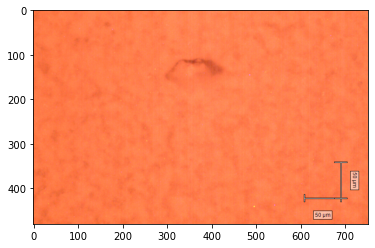

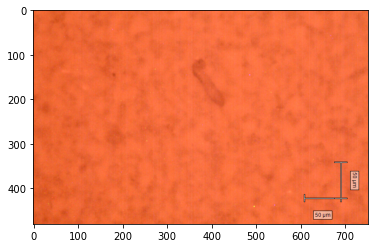

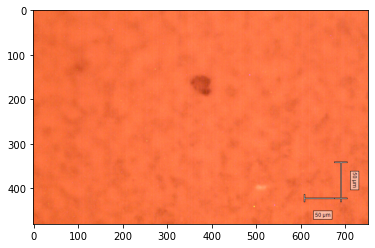

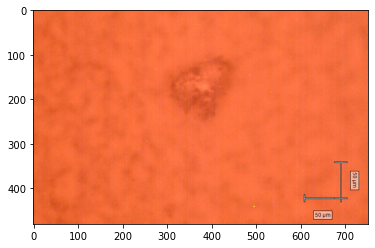

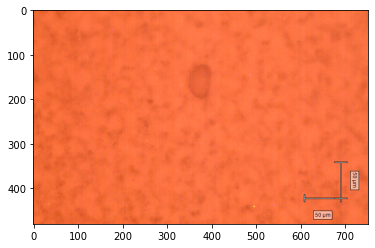

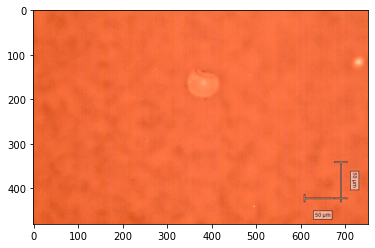

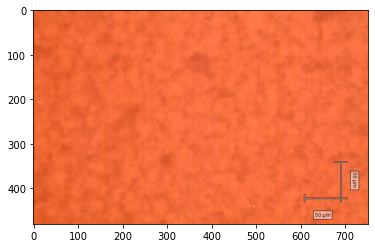

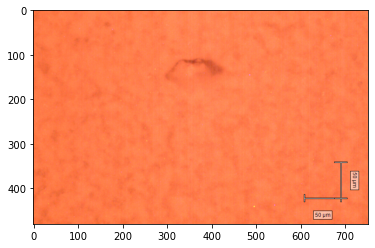

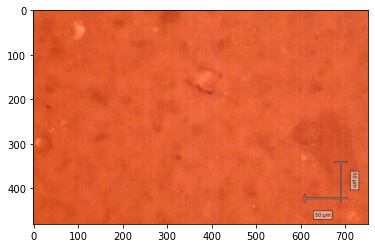

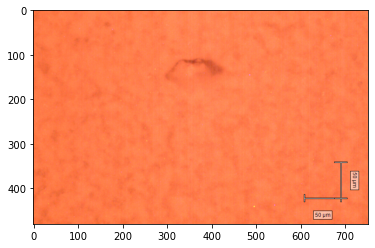

In [43]:
count = 0
for im in samples:
    if type(im) != type(None):
        plt.figure(count)
        plt.imshow(im)
        count+=1

In [40]:
type(samples[8])

NoneType

# Things to improve/fix
* if data is for sure consistent. Take datacleaning steps, generalize, and put into a function. Then 10x_dataset class with get passed in the filename of the labels and in the init method the dataclean function should be called.
* Verify the labels are coming through (i.e. train some sort of model on this data
* Make sure the nonetypes are because the file actually isn't in my folder of images
* Figure out why I'm getting duplicate images